In [1]:
# import necessary libs
import json
import random
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

rand_seed = 555

In [2]:
# open the intents
with open("../Final_Intents.json") as intents_json_file:
    intents = json.load(intents_json_file)

In [3]:
# inspect the keys (should be tag, questions, responses)
intent_list_keys = []
for intent in intents:
    intent_list_keys += list(intent.keys())

set(intent_list_keys)

{'questions', 'responses', 'tag'}

In [5]:
lemmatizer = WordNetLemmatizer()

def preprocess_intent_list(intents: list[list[str]], qna=False):
    """Preprocesses text data for training
    """
    words = []
    classes = []
    documents = []
    ignoreLetters = ['?', '!', '.', ',']

    for intent in intents:
        for question in intent['questions']:
            wordList = nltk.word_tokenize(question)
            words.extend(wordList)
            documents.append((wordList, intent['tag']))
            if intent['tag'] not in classes:
                classes.append(intent['tag'])
        if qna:
            # responses
            for response in intent['responses']:
                wordList = nltk.word_tokenize(response)
                words.extend(wordList)
                documents.append((wordList, intent['tag']))

    
    words = [lemmatizer.lemmatize(word) for word in words if
         word not in ignoreLetters]

    words = sorted(set(words))
    
    classes = sorted(set(classes))

    training = []
    # zeros
    outputEmpty = [0] * len(classes)

    for document in documents:
        bag = []
        wordPatterns = document[0]
        # lemmatize word patterns
        wordPatterns = [lemmatizer.lemmatize(word.lower()) for word in wordPatterns]
        # create bag of words
        for word in words:
            bag.append(1) if word in wordPatterns else bag.append(0)

        outputRow = list(outputEmpty)
        outputRow[classes.index(document[1])] += 1
        training.append(bag + outputRow)

    random.shuffle(training)
    training = np.array(training)

    return training, set(words), classes


In [6]:
training, words, classes = preprocess_intent_list(intents)

# Separate the features (X) and labels (Y)
trainX = training[:, :len(words)]
trainY = training[:, len(words):]

trainX.shape, trainY.shape

((524, 741), (524, 10))

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    """Function to visualize model performance
    """
    history = results.history
    plt.figure()
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# input_dim is the number of features in your input data
input_dim = len(words)

# Create a Sequential model
base_model = Sequential()

# Add a Dense layer with 128 units/neurons and 'relu' activation function
base_model.add(Dense(128, input_dim=input_dim, activation='relu'))

# Add another Dense layer with 64 neurons
base_model.add(Dense(64, activation='relu'))

# Add the output layer with appropriate units and activation function
base_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the summary of the model
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               94976     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 103,882
Trainable params: 103,882
Non-trainable params: 0
_________________________________________________________________


2024-01-25 07:46:14.682299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# train the model
base_model_results = base_model.fit(trainX, trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
84/84 [==============================] - 1s 3ms/step - loss: 1.9084 - accuracy: 0.3866 - val_loss: 1.5370 - val_accuracy: 0.4762
Epoch 2/200
84/84 [==============================] - 0s 2ms/step - loss: 1.3185 - accuracy: 0.5656 - val_loss: 1.2657 - val_accuracy: 0.6476
Epoch 3/200
84/84 [==============================] - 0s 2ms/step - loss: 0.8312 - accuracy: 0.7828 - val_loss: 1.0376 - val_accuracy: 0.6667
Epoch 4/200
84/84 [==============================] - 0s 2ms/step - loss: 0.4764 - accuracy: 0.8950 - val_loss: 0.9808 - val_accuracy: 0.6667
Epoch 5/200
84/84 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.9379 - val_loss: 1.0230 - val_accuracy: 0.6762
Epoch 6/200
84/84 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9809 - val_loss: 0.9596 - val_accuracy: 0.7048
Epoch 7/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0994 - accuracy: 0.9928 - val_loss: 1.0317 - val_accuracy: 0.6762
Epoch 8/200
8

Epoch 59/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 0.9952 - val_loss: 1.7623 - val_accuracy: 0.6286
Epoch 60/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9952 - val_loss: 1.7775 - val_accuracy: 0.6381
Epoch 61/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9952 - val_loss: 1.7873 - val_accuracy: 0.6286
Epoch 62/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9976 - val_loss: 1.8030 - val_accuracy: 0.6286
Epoch 63/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9952 - val_loss: 1.8148 - val_accuracy: 0.6286
Epoch 64/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9976 - val_loss: 1.8385 - val_accuracy: 0.6476
Epoch 65/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9976 - val_loss: 1.8441 - val_accuracy: 0.6286
Epoch 

84/84 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9976 - val_loss: 3.2665 - val_accuracy: 0.6190
Epoch 174/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9976 - val_loss: 3.2815 - val_accuracy: 0.6190
Epoch 175/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9976 - val_loss: 3.2984 - val_accuracy: 0.6190
Epoch 176/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9952 - val_loss: 3.2872 - val_accuracy: 0.6190
Epoch 177/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9952 - val_loss: 3.3041 - val_accuracy: 0.6190
Epoch 178/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9976 - val_loss: 3.3180 - val_accuracy: 0.6190
Epoch 179/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9976 - val_loss: 3.3431 - val_accuracy: 0.6190
Epoch 180/200

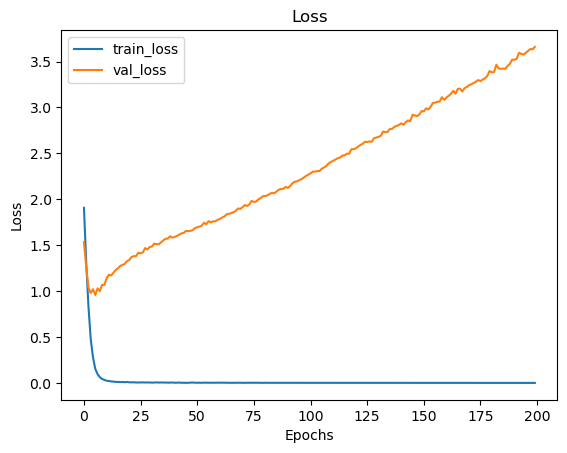

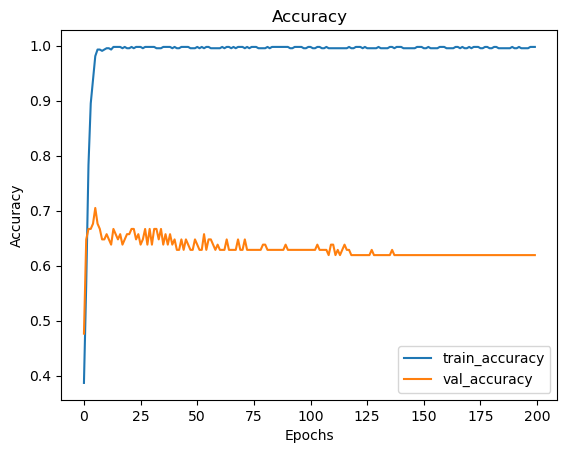

In [10]:
# visualize training results 
visualize_training_results(base_model_results)

### Summary of the `Base Model` Performance:

#### Key Observations:
1. **Overfitting Concerns:**
   - The training accuracy remains high **(around 98%)**, suggesting the model has learned well from the training data.
   - However, the validation accuracy has plateaued around **30-40%**, indicating a significant performance gap between training and validation sets.

2. **Validation Loss:**
   - The validation loss has increased substantially in the later epochs, reaching around 9.8. This further supports the overfitting concern.

#### Suggestions for Next Steps:
1. **Train on both questions and responses:** 
    - Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.
    
1. **Overfitting Mitigation - Regularization:**
   - Incorporating regularization techniques like dropout or L2 regularization to prevent overfitting. This may help the model generalize better to unseen data.
1. **Performance improvement mitigation:**
    - Overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:
    1. **Learning Rate Tuning:**
       - Experiment with different learning rates. 

    1. **Optimize the number of hidden layers**:
        - Tune the model by finding the appropriate number of hidden layers.

    1. **Testing out different vectorization methods.**
       - Test out the following vectorization strategies:
           - `TFIDF`
           - `embeddings`

1. If all fail, pick out a different deep learning model and repeat the above steps

### 1. Train on both questions and responses:
Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.

In [11]:
QnA_training, QnA_words, classes = preprocess_intent_list(intents, qna=True)

# Separate the features (X) and labels (Y) for each set
QnA_trainX = QnA_training[:, :len(QnA_words)]
QnA_trainY = QnA_training[:, len(QnA_words):]

In [12]:
QnA_trainX.shape, QnA_trainY.shape

((1040, 1880), (1040, 10))

In [13]:
# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model - same as the base model
model_2 = Sequential()
model_2.add(Dense(128, input_dim=input_dim, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model_2_results = model_2.fit(QnA_trainX, QnA_trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
167/167 [==============================] - 1s 3ms/step - loss: 1.6970 - accuracy: 0.4399 - val_loss: 1.2085 - val_accuracy: 0.6202
Epoch 2/200
167/167 [==============================] - 0s 2ms/step - loss: 0.7078 - accuracy: 0.8137 - val_loss: 0.7655 - val_accuracy: 0.7692
Epoch 3/200
167/167 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy: 0.9507 - val_loss: 0.6358 - val_accuracy: 0.8077
Epoch 4/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9808 - val_loss: 0.6568 - val_accuracy: 0.8125
Epoch 5/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0505 - accuracy: 0.9880 - val_loss: 0.6940 - val_accuracy: 0.8029
Epoch 6/200
167/167 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9988 - val_loss: 0.6856 - val_accuracy: 0.8269
Epoch 7/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9976 - val_loss: 0.7100 - val_accuracy: 0.8173

Epoch 57/200
167/167 [==============================] - 0s 2ms/step - loss: 1.1968e-05 - accuracy: 1.0000 - val_loss: 1.2886 - val_accuracy: 0.7981
Epoch 58/200
167/167 [==============================] - 0s 2ms/step - loss: 1.1073e-05 - accuracy: 1.0000 - val_loss: 1.2949 - val_accuracy: 0.7981
Epoch 59/200
167/167 [==============================] - 0s 2ms/step - loss: 9.9370e-06 - accuracy: 1.0000 - val_loss: 1.3016 - val_accuracy: 0.7933
Epoch 60/200
167/167 [==============================] - 0s 2ms/step - loss: 9.0543e-06 - accuracy: 1.0000 - val_loss: 1.3115 - val_accuracy: 0.7981
Epoch 61/200
167/167 [==============================] - 0s 3ms/step - loss: 8.2072e-06 - accuracy: 1.0000 - val_loss: 1.3240 - val_accuracy: 0.7933
Epoch 62/200
167/167 [==============================] - 0s 2ms/step - loss: 7.4321e-06 - accuracy: 1.0000 - val_loss: 1.3297 - val_accuracy: 0.7933
Epoch 63/200
167/167 [==============================] - 0s 2ms/step - loss: 6.7848e-06 - accuracy: 1.0000 - val_

167/167 [==============================] - 0s 2ms/step - loss: 2.4358e-09 - accuracy: 1.0000 - val_loss: 2.1672 - val_accuracy: 0.7692
Epoch 168/200
167/167 [==============================] - 0s 2ms/step - loss: 1.8626e-09 - accuracy: 1.0000 - val_loss: 2.1846 - val_accuracy: 0.7740
Epoch 169/200
167/167 [==============================] - 0s 3ms/step - loss: 2.0059e-09 - accuracy: 1.0000 - val_loss: 2.1806 - val_accuracy: 0.7740
Epoch 170/200
167/167 [==============================] - 0s 2ms/step - loss: 2.7223e-09 - accuracy: 1.0000 - val_loss: 2.1809 - val_accuracy: 0.7740
Epoch 171/200
167/167 [==============================] - 0s 2ms/step - loss: 1.8626e-09 - accuracy: 1.0000 - val_loss: 2.1885 - val_accuracy: 0.7740
Epoch 172/200
167/167 [==============================] - 0s 2ms/step - loss: 2.2925e-09 - accuracy: 1.0000 - val_loss: 2.1977 - val_accuracy: 0.7740
Epoch 173/200
167/167 [==============================] - 0s 2ms/step - loss: 1.7194e-09 - accuracy: 1.0000 - val_loss: 2

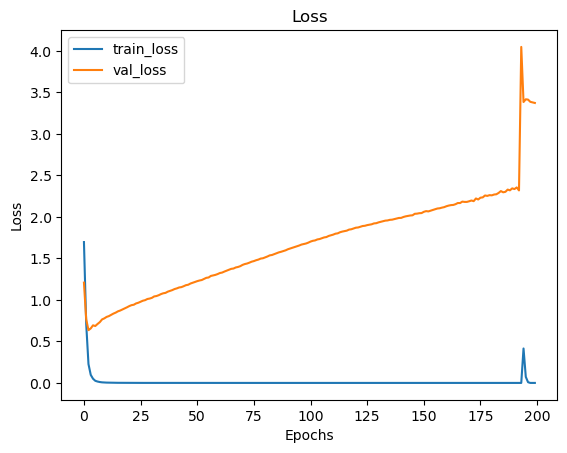

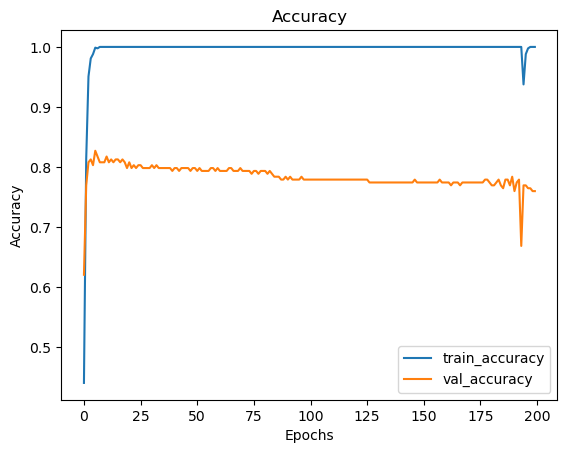

In [14]:
# visualize training results 
visualize_training_results(model_2_results)

### Summary of `model_2`:
 #### Key Observations:
1. **Training and Validation Metrics:**
   - The training accuracy has increased to approximately **99.42%**, while the validation accuracy has improved to around **58.78%**.
   - The training loss has decreased, reaching approximately 0.0084, and the validation loss is at 5.9267.

#### Progress and Adjustments:
1. **Performance Improvement:**
   - The model's performance has significantly improved compared to the previous iterations.

2. **Validation Accuracy:**
   - While the validation accuracy has increased, there may still be room for further improvement.

## 2. Regularization - Dropout regularization

In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model
model_2_reg = Sequential()

# Add a Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.7))

# Add another Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.5))

# Output layer
model_2_reg.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization
model_2_reg_results = model_2_reg.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=5, verbose=1, validation_split=0.2)


Epoch 1/250
167/167 [==============================] - 1s 3ms/step - loss: 2.7727 - accuracy: 0.3474 - val_loss: 2.0124 - val_accuracy: 0.4519
Epoch 2/250
167/167 [==============================] - 0s 3ms/step - loss: 1.9245 - accuracy: 0.4639 - val_loss: 1.7646 - val_accuracy: 0.5048
Epoch 3/250
167/167 [==============================] - 0s 3ms/step - loss: 1.7338 - accuracy: 0.5469 - val_loss: 1.6566 - val_accuracy: 0.5962
Epoch 4/250
167/167 [==============================] - 0s 3ms/step - loss: 1.5784 - accuracy: 0.6142 - val_loss: 1.5711 - val_accuracy: 0.6490
Epoch 5/250
167/167 [==============================] - 0s 3ms/step - loss: 1.5092 - accuracy: 0.6683 - val_loss: 1.5252 - val_accuracy: 0.6971
Epoch 6/250
167/167 [==============================] - 0s 3ms/step - loss: 1.4515 - accuracy: 0.7007 - val_loss: 1.4995 - val_accuracy: 0.7019
Epoch 7/250
167/167 [==============================] - 1s 3ms/step - loss: 1.3651 - accuracy: 0.7416 - val_loss: 1.4449 - val_accuracy: 0.7019

Epoch 58/250
167/167 [==============================] - 0s 3ms/step - loss: 0.9630 - accuracy: 0.8642 - val_loss: 1.2454 - val_accuracy: 0.7837
Epoch 59/250
167/167 [==============================] - 1s 3ms/step - loss: 0.9606 - accuracy: 0.8810 - val_loss: 1.2593 - val_accuracy: 0.7837
Epoch 60/250
167/167 [==============================] - 0s 3ms/step - loss: 0.9167 - accuracy: 0.8906 - val_loss: 1.2472 - val_accuracy: 0.7933
Epoch 61/250
167/167 [==============================] - 1s 3ms/step - loss: 0.8934 - accuracy: 0.8870 - val_loss: 1.2526 - val_accuracy: 0.7885
Epoch 62/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8955 - accuracy: 0.8870 - val_loss: 1.2646 - val_accuracy: 0.7837
Epoch 63/250
167/167 [==============================] - 0s 3ms/step - loss: 0.9416 - accuracy: 0.8690 - val_loss: 1.2466 - val_accuracy: 0.7981
Epoch 64/250
167/167 [==============================] - 0s 3ms/step - loss: 0.9569 - accuracy: 0.8786 - val_loss: 1.2378 - val_accuracy:

Epoch 115/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8453 - accuracy: 0.9026 - val_loss: 1.1886 - val_accuracy: 0.8029
Epoch 116/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8358 - accuracy: 0.9050 - val_loss: 1.1893 - val_accuracy: 0.7740
Epoch 117/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8404 - accuracy: 0.9050 - val_loss: 1.1866 - val_accuracy: 0.7981
Epoch 118/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8514 - accuracy: 0.9002 - val_loss: 1.2023 - val_accuracy: 0.7885
Epoch 119/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8330 - accuracy: 0.9062 - val_loss: 1.2192 - val_accuracy: 0.8029
Epoch 120/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8389 - accuracy: 0.9111 - val_loss: 1.2159 - val_accuracy: 0.7885
Epoch 121/250
167/167 [==============================] - 1s 3ms/step - loss: 0.8722 - accuracy: 0.8882 - val_loss: 1.1999 - val_ac

167/167 [==============================] - 0s 3ms/step - loss: 0.8279 - accuracy: 0.8954 - val_loss: 1.1934 - val_accuracy: 0.7933
Epoch 228/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8424 - accuracy: 0.8870 - val_loss: 1.1776 - val_accuracy: 0.7933
Epoch 229/250
167/167 [==============================] - 0s 3ms/step - loss: 0.7944 - accuracy: 0.9038 - val_loss: 1.2475 - val_accuracy: 0.7885
Epoch 230/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8033 - accuracy: 0.9038 - val_loss: 1.2510 - val_accuracy: 0.7837
Epoch 231/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8336 - accuracy: 0.8954 - val_loss: 1.2313 - val_accuracy: 0.7740
Epoch 232/250
167/167 [==============================] - 0s 3ms/step - loss: 0.7988 - accuracy: 0.9135 - val_loss: 1.2335 - val_accuracy: 0.7548
Epoch 233/250
167/167 [==============================] - 1s 3ms/step - loss: 0.8093 - accuracy: 0.9014 - val_loss: 1.2347 - val_accuracy: 0.7644

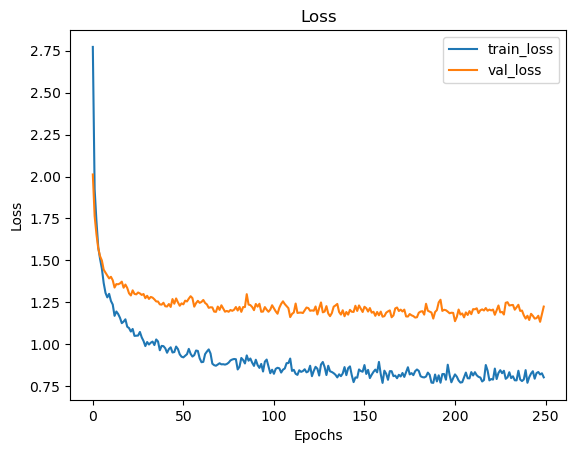

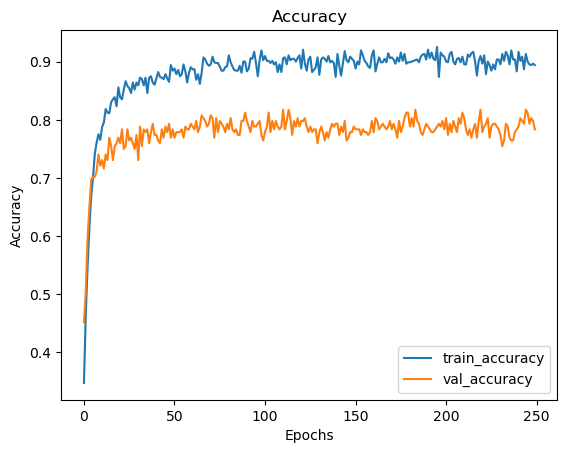

In [16]:
visualize_training_results(model_2_reg_results)

### Model Training Update:

#### Key Training Metrics:
1. **Accuracy:**
   - Training Accuracy: ~84%
   - Validation Accuracy: ~60%
  
2. **Loss:**
   - Training Loss: ~1.32
   - Validation Loss: ~3.55

#### Observations:
1. **Reduced overfitting:**
   - Even though the training accuracy remains relatively high, there is a noticeable reduction in overfitting.

2. **Loss Trends:**
   - The training loss is lower than previous epochs, indicating continued learning. However, the validation loss is relatively high.


### 3. Performance improvement mitigation:
Any form of overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:

#### 3.1 Learning Rate Tuning:
- Experiment with a different learning rate.

In [17]:
from keras.optimizers import Adam

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
84/84 [==============================] - 1s 4ms/step - loss: 2.5942 - accuracy: 0.3534 - val_loss: 1.7795 - val_accuracy: 0.4471
Epoch 2/250
84/84 [==============================] - 0s 4ms/step - loss: 1.7165 - accuracy: 0.4471 - val_loss: 1.5174 - val_accuracy: 0.5625
Epoch 3/250
84/84 [==============================] - 0s 3ms/step - loss: 1.4500 - accuracy: 0.6046 - val_loss: 1.3459 - val_accuracy: 0.6875
Epoch 4/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2551 - accuracy: 0.6839 - val_loss: 1.2436 - val_accuracy: 0.7067
Epoch 5/250
84/84 [==============================] - 0s 3ms/step - loss: 1.0777 - accuracy: 0.7788 - val_loss: 1.1601 - val_accuracy: 0.7260
Epoch 6/250
84/84 [==============================] - 0s 3ms/step - loss: 0.9401 - accuracy: 0.8233 - val_loss: 1.1222 - val_accuracy: 0.7308
Epoch 7/250
84/84 [==============================] - 0s 3ms/step - loss: 0.8727 - accuracy: 0.8269 - val_loss: 1.0866 - val_accuracy: 0.7500
Epoch 8/250
8

Epoch 59/250
84/84 [==============================] - 0s 4ms/step - loss: 0.4548 - accuracy: 0.9555 - val_loss: 1.0721 - val_accuracy: 0.7933
Epoch 60/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.9615 - val_loss: 1.0559 - val_accuracy: 0.8077
Epoch 61/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4727 - accuracy: 0.9483 - val_loss: 1.0473 - val_accuracy: 0.8029
Epoch 62/250
84/84 [==============================] - 0s 4ms/step - loss: 0.4811 - accuracy: 0.9543 - val_loss: 1.0900 - val_accuracy: 0.8029
Epoch 63/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4073 - accuracy: 0.9832 - val_loss: 1.0766 - val_accuracy: 0.8125
Epoch 64/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4284 - accuracy: 0.9651 - val_loss: 1.0423 - val_accuracy: 0.8029
Epoch 65/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.9663 - val_loss: 1.0565 - val_accuracy: 0.7933
Epoch 

84/84 [==============================] - 0s 3ms/step - loss: 0.4193 - accuracy: 0.9675 - val_loss: 1.1376 - val_accuracy: 0.7740
Epoch 174/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4043 - accuracy: 0.9663 - val_loss: 1.1284 - val_accuracy: 0.7740
Epoch 175/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3793 - accuracy: 0.9700 - val_loss: 1.0621 - val_accuracy: 0.7981
Epoch 176/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3750 - accuracy: 0.9700 - val_loss: 1.0574 - val_accuracy: 0.8269
Epoch 177/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4155 - accuracy: 0.9615 - val_loss: 1.0839 - val_accuracy: 0.8317
Epoch 178/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.9663 - val_loss: 1.1188 - val_accuracy: 0.7837
Epoch 179/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3754 - accuracy: 0.9639 - val_loss: 1.1538 - val_accuracy: 0.7837
Epoch 180/250

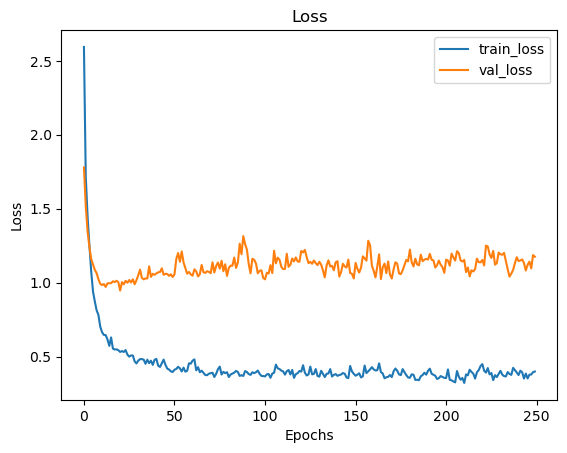

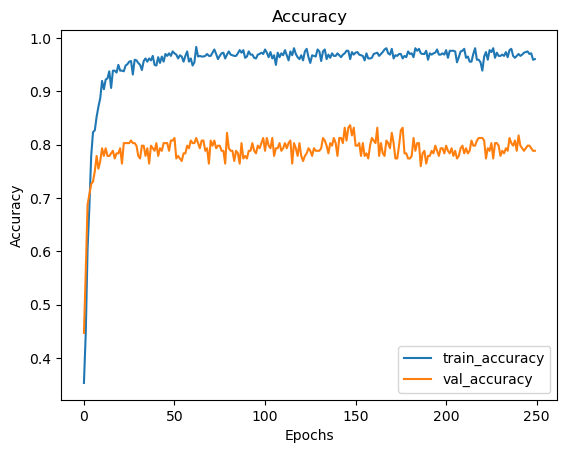

In [18]:
visualize_training_results(model_2_reg_results_opt)

### 3.2 Optimize the number of hidden layers:

Tune the model by finding the:
- appropriate number of hidden layers
- the number of neurons per layer.

In [19]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(50, activation='relu'))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
84/84 [==============================] - 1s 5ms/step - loss: 4.0279 - accuracy: 0.3858 - val_loss: 3.3813 - val_accuracy: 0.4471
Epoch 2/250
84/84 [==============================] - 0s 3ms/step - loss: 3.1394 - accuracy: 0.4291 - val_loss: 2.7523 - val_accuracy: 0.5000
Epoch 3/250
84/84 [==============================] - 0s 4ms/step - loss: 2.6334 - accuracy: 0.4784 - val_loss: 2.4454 - val_accuracy: 0.5000
Epoch 4/250
84/84 [==============================] - 0s 3ms/step - loss: 2.2393 - accuracy: 0.5300 - val_loss: 2.0703 - val_accuracy: 0.5577
Epoch 5/250
84/84 [==============================] - 0s 3ms/step - loss: 1.9395 - accuracy: 0.5661 - val_loss: 1.8853 - val_accuracy: 0.5529
Epoch 6/250
84/84 [==============================] - 0s 4ms/step - loss: 1.7231 - accuracy: 0.6118 - val_loss: 1.7006 - val_accuracy: 0.6106
Epoch 7/250
84/84 [==============================] - 0s 3ms/step - loss: 1.5196 - accuracy: 0.6659 - val_loss: 1.6506 - val_accuracy: 0.6779
Epoch 8/250
8

Epoch 59/250
84/84 [==============================] - 0s 3ms/step - loss: 1.3222 - accuracy: 0.8197 - val_loss: 1.5284 - val_accuracy: 0.7548
Epoch 60/250
84/84 [==============================] - 0s 3ms/step - loss: 1.4818 - accuracy: 0.7957 - val_loss: 1.5172 - val_accuracy: 0.7596
Epoch 61/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2440 - accuracy: 0.8582 - val_loss: 1.5321 - val_accuracy: 0.7356
Epoch 62/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2729 - accuracy: 0.8413 - val_loss: 1.5475 - val_accuracy: 0.7452
Epoch 63/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2173 - accuracy: 0.8474 - val_loss: 1.5975 - val_accuracy: 0.7500
Epoch 64/250
84/84 [==============================] - 0s 3ms/step - loss: 1.3347 - accuracy: 0.8089 - val_loss: 1.4833 - val_accuracy: 0.7452
Epoch 65/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2353 - accuracy: 0.8450 - val_loss: 1.5164 - val_accuracy: 0.7452
Epoch 

84/84 [==============================] - 0s 3ms/step - loss: 1.3267 - accuracy: 0.8005 - val_loss: 1.5149 - val_accuracy: 0.7500
Epoch 174/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2918 - accuracy: 0.8173 - val_loss: 1.4350 - val_accuracy: 0.7692
Epoch 175/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2114 - accuracy: 0.8389 - val_loss: 1.4418 - val_accuracy: 0.7548
Epoch 176/250
84/84 [==============================] - 0s 3ms/step - loss: 1.1643 - accuracy: 0.8438 - val_loss: 1.3593 - val_accuracy: 0.7500
Epoch 177/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2453 - accuracy: 0.8101 - val_loss: 1.4263 - val_accuracy: 0.7356
Epoch 178/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2013 - accuracy: 0.8462 - val_loss: 1.3612 - val_accuracy: 0.7452
Epoch 179/250
84/84 [==============================] - 0s 3ms/step - loss: 1.1770 - accuracy: 0.8486 - val_loss: 1.5576 - val_accuracy: 0.7356
Epoch 180/250

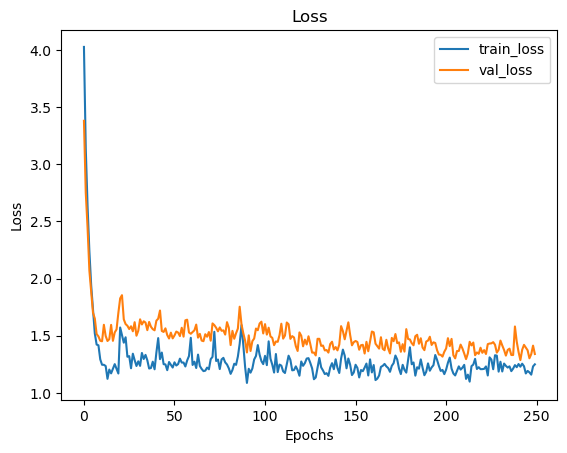

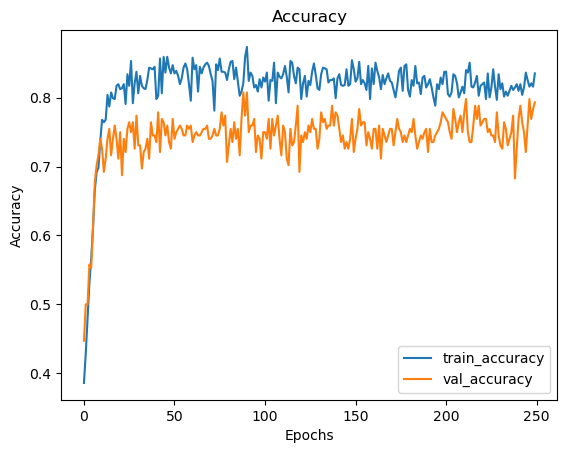

In [20]:
visualize_training_results(model_2_reg_results_opt)

### 3.3 Testing out different vectorization methods.
Test out the following vectorization strategies:
   - `TFIDF`
   - `embeddings`


### 3.3.1 Term Frequency * Inverse Document Frequency (TFIDF) vectorization

In [21]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
ignoreLetters = ['?', '!', '.', ',']
    
def preprocess_qnas(df):
    # Lowercase all text in the "QnAs" column
    df['QnAs'] = df['QnAs'].str.lower()
    
    # Tokenize the text in the "QnAs" column
    df['QnAs'] = df['QnAs'].apply(word_tokenize)
    
    # Remove stopwords from the tokenized text in the "QnAs" column
    stop_words = set(stopwords.words('english'))
    
    df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
    df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in ignoreLetters])

    df['QnAs'] = df['QnAs'].apply(lambda x: " ".join(x))
    
    return  df



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
import json
import pandas as pd
from nltk.stem import WordNetLemmatizer
import numpy as np

lemmatizer = WordNetLemmatizer()

# open the intents
with open("../Final_Intents.json") as intents_json_file:
    intents = json.load(intents_json_file)

QnAs = []
tags = []

for intent in intents:
    for question in intent["questions"]:
        QnAs.append(question)
        tags.append(intent['tag'])
    for response in intent["responses"]:
        QnAs.append(response)
        tags.append(intent['tag'])
# Preprocess the text by lemmatizing and lowercasing

qna_df = pd.DataFrame({"QnAs": QnAs, "tags": tags})

qna_df["QnAs"] = qna_df["QnAs"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) for word in x.split()]))

qna_df = qna_df.reindex(np.random.permutation(qna_df.index))
qna_df = preprocess_qnas(qna_df)
qna_df.head()

,QnAs,tags
484,pursue career cybersecurity background compute...,Cybersecurity
75,long doe data science pre-work take complete,Data Science
12,doe data science course prepare student succes...,Data Science
284,pre-work cover introductory concept data scien...,Data Science
220,demand data scientist exceptionally high indus...,Data Science


In [26]:
from sklearn.preprocessing import LabelEncoder

# Fit label encoder on all unique labels
label_encoder = LabelEncoder()
label_encoder.fit(qna_df["tags"].unique())

# Transform unique labels to numerical values
unique_labels = qna_df["tags"].unique()
encoded_labels = label_encoder.transform(unique_labels)

# Create a mapping dictionary
tag_labels = {val: key for key, val in zip(encoded_labels, unique_labels)}

# Replace tags in the DataFrame
qna_df["tags"] = qna_df["tags"].replace(tag_labels)

# Display the updated DataFrame
qna_df["tags"].head()

484    2
75     3
12     3
284    3
220    3
Name: tags, dtype: int64

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=0, max_features=None, strip_accents='unicode', analyzer='word', stop_words='english')
# vectorizer = CountVectorizer()

X_vectorized = vectorizer.fit_transform(qna_df["QnAs"])

trainX_idf = X_vectorized.todense()

trainY_idf = pd.get_dummies(qna_df["tags"])


# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(trainX_idf, qna_df["tags"])


trainX_idf = X_resampled

trainY_idf = pd.get_dummies(y_resampled)

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [51]:
# y_resampled

In [52]:
trainX_idf.shape, trainY_idf.shape

((4190, 1579), (4190, 10))

In [55]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential

sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

input_dim = trainX_idf.shape[1]

classes = set(tags)

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model_2_reg_opt.add(Dropout(0.8))

# hidden layers
model_2_reg_opt.add(Dense(64, activation='tanh'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(150, activation='tanh'))
model_2_reg_opt.add(Dropout(0.5))
# model_2_reg_opt.add(Dense(64, activation='relu'))
# model_2_reg_opt.add(Dropout(0.6))

# Output layer
model_2_reg_opt.add(Dense(trainY_idf.shape[1], activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# summary
model_2_reg_results_opt = model_2_reg_opt.fit(trainX_idf, trainY_idf, epochs=250, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/250
671/671 [==============================] - 2s 3ms/step - loss: 4.2920 - accuracy: 0.1599 - val_loss: 4.9252 - val_accuracy: 0.0000e+00
Epoch 2/250
671/671 [==============================] - 2s 3ms/step - loss: 3.6334 - accuracy: 0.3013 - val_loss: 4.5952 - val_accuracy: 0.0000e+00
Epoch 3/250
671/671 [==============================] - 2s 3ms/step - loss: 2.8904 - accuracy: 0.5337 - val_loss: 4.1778 - val_accuracy: 0.0465
Epoch 4/250
671/671 [==============================] - 2s 3ms/step - loss: 2.1652 - accuracy: 0.6865 - val_loss: 3.7936 - val_accuracy: 0.1444
Epoch 5/250
671/671 [==============================] - 2s 3ms/step - loss: 1.7049 - accuracy: 0.7661 - val_loss: 3.4886 - val_accuracy: 0.1551
Epoch 6/250
671/671 [==============================] - 2s 3ms/step - loss: 1.3824 - accuracy: 0.8121 - val_loss: 3.0755 - val_accuracy: 0.1766
Epoch 7/250
671/671 [==============================] - 2s 3ms/step - loss: 1.1975 - accuracy: 0.8308 - val_loss: 3.0452 - val_accuracy

Epoch 58/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6959 - accuracy: 0.9021 - val_loss: 0.6957 - val_accuracy: 0.9033
Epoch 59/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6576 - accuracy: 0.9126 - val_loss: 0.6973 - val_accuracy: 0.8950
Epoch 60/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6746 - accuracy: 0.9030 - val_loss: 0.6129 - val_accuracy: 0.9427
Epoch 61/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6419 - accuracy: 0.9162 - val_loss: 0.6562 - val_accuracy: 0.9105
Epoch 62/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6264 - accuracy: 0.9156 - val_loss: 0.8071 - val_accuracy: 0.8687
Epoch 63/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6555 - accuracy: 0.9072 - val_loss: 0.7732 - val_accuracy: 0.8508
Epoch 64/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6827 - accuracy: 0.9072 - val_loss: 0.7150 - val_accuracy:

Epoch 115/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6059 - accuracy: 0.9224 - val_loss: 0.4531 - val_accuracy: 0.9821
Epoch 116/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6259 - accuracy: 0.9195 - val_loss: 0.6608 - val_accuracy: 0.8974
Epoch 117/250
671/671 [==============================] - 1s 2ms/step - loss: 0.6515 - accuracy: 0.9114 - val_loss: 0.5213 - val_accuracy: 0.9427
Epoch 118/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6432 - accuracy: 0.9120 - val_loss: 0.5595 - val_accuracy: 0.9594
Epoch 119/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6354 - accuracy: 0.9168 - val_loss: 0.6013 - val_accuracy: 0.9535
Epoch 120/250
671/671 [==============================] - 1s 2ms/step - loss: 0.6090 - accuracy: 0.9248 - val_loss: 0.5688 - val_accuracy: 0.9332
Epoch 121/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6634 - accuracy: 0.9147 - val_loss: 0.5317 - val_ac

671/671 [==============================] - 1s 2ms/step - loss: 0.6268 - accuracy: 0.9215 - val_loss: 0.6213 - val_accuracy: 0.9236
Epoch 172/250
671/671 [==============================] - 2s 2ms/step - loss: 0.5941 - accuracy: 0.9323 - val_loss: 0.5520 - val_accuracy: 0.9224
Epoch 173/250
671/671 [==============================] - 1s 2ms/step - loss: 0.6192 - accuracy: 0.9197 - val_loss: 0.5667 - val_accuracy: 0.9344
Epoch 174/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6228 - accuracy: 0.9195 - val_loss: 0.5391 - val_accuracy: 0.9558
Epoch 175/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6046 - accuracy: 0.9266 - val_loss: 0.4732 - val_accuracy: 0.9654
Epoch 176/250
671/671 [==============================] - 2s 2ms/step - loss: 0.6263 - accuracy: 0.9227 - val_loss: 0.5058 - val_accuracy: 0.9666
Epoch 177/250
671/671 [==============================] - 1s 2ms/step - loss: 0.6208 - accuracy: 0.9263 - val_loss: 0.5285 - val_accuracy: 0.9487

671/671 [==============================] - 2s 3ms/step - loss: 0.6097 - accuracy: 0.9335 - val_loss: 0.4762 - val_accuracy: 0.9737
Epoch 228/250
671/671 [==============================] - 2s 3ms/step - loss: 0.5994 - accuracy: 0.9242 - val_loss: 0.5368 - val_accuracy: 0.9487
Epoch 229/250
671/671 [==============================] - 2s 3ms/step - loss: 0.5876 - accuracy: 0.9272 - val_loss: 0.5071 - val_accuracy: 0.9630
Epoch 230/250
671/671 [==============================] - 2s 3ms/step - loss: 0.5944 - accuracy: 0.9272 - val_loss: 0.5190 - val_accuracy: 0.9511
Epoch 231/250
671/671 [==============================] - 2s 3ms/step - loss: 0.5905 - accuracy: 0.9248 - val_loss: 0.5435 - val_accuracy: 0.9582
Epoch 232/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6315 - accuracy: 0.9177 - val_loss: 0.4877 - val_accuracy: 0.9809
Epoch 233/250
671/671 [==============================] - 2s 3ms/step - loss: 0.6348 - accuracy: 0.9177 - val_loss: 0.4966 - val_accuracy: 0.9726

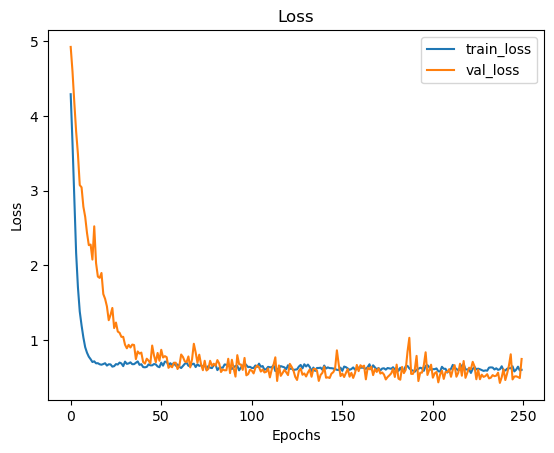

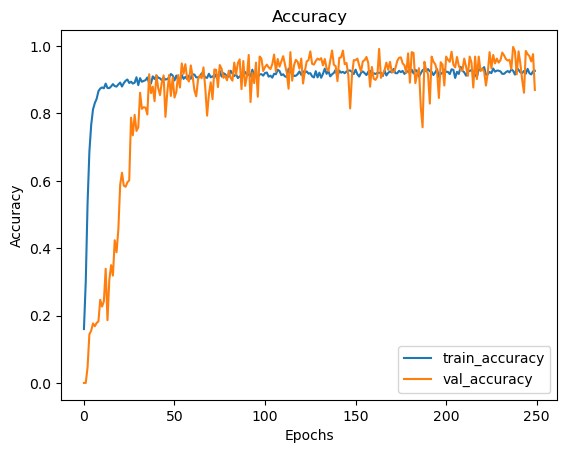

In [56]:
visualize_training_results(model_2_reg_results_opt)

In [32]:
unique_labels

array(['Cybersecurity', 'Data Science', 'Miscellaneous',
       'Cloud Computing', 'Software Engineering', 'DevOps', 'UI/UX',
       'Contacts', 'Mobile Development', 'Enrollment'], dtype=object)

In [88]:
import string

def clean_text(sentence):
    lower = sentence.lower()
    toks = word_tokenize(lower)
    stop_words = set(stopwords.words('english'))
    toks = [word for word in toks if word not in ignoreLetters]
    sentence = [word for word in sentence if word not in stop_words]
    print(f"toks: {toks}\n")
    return toks
    
# test
clean_text("Remove punctuations and return lemmatized tokens ?")

toks: ['remove', 'punctuations', 'and', 'return', 'lemmatized', 'tokens']



['remove', 'punctuations', 'and', 'return', 'lemmatized', 'tokens']

In [35]:
classes

{'Cloud Computing',
 'Contacts',
 'Cybersecurity',
 'Data Science',
 'DevOps',
 'Enrollment',
 'Miscellaneous',
 'Mobile Development',
 'Software Engineering',
 'UI/UX'}

In [39]:
vectorized_txt

<10x1637 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [91]:
# example
text = "What is the fundamental starting point for understanding Cloud Computing ?"

prep_text = clean_text(text)
vectorized_txt = vectorizer.transform(prep_text)

pred = model_2_reg_opt.predict([vectorized_txt])

ERR_THRESH = 0.25

unique_labels = qna_df["tags"].unique()

results = {np.argmax(r): r[np.argmax(r)] for i, r in enumerate(pred) if any(r > ERR_THRESH)}
results = dict(sorted(results.items(), key=lambda k: k[0]))

print(f"\nPredicted classes: {results}")
for class_key, conf in results.items():
    print(f"{class_key}: {label_encoder.classes_[class_key]}, {round(conf*100)}%")

toks: ['what', 'is', 'the', 'fundamental', 'starting', 'point', 'for', 'understanding', 'cloud', 'computing']

1/1 [==============================] - 0s 5ms/step

Predicted classes: {0: 1.0, 3: 0.7198617}
0: Cloud Computing, 100%
3: Data Science, 72%


In [71]:
model_2_reg_opt.save("chatbot.model")

INFO:tensorflow:Assets written to: chatbot.model/assets
